# Import Libraries

In [ ]:
import basemodel as bp
import numpy as np
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.framework.formats import landmark_pb2
from mediapipe.python.solutions import drawing_utils, hands

# Prepare Data

In [229]:
import torchvision
import torchvision.transforms as transforms
import numpy as np

def preprocess_dataset(path):
    # Initialize transformation: format as tensor, normalize
    transform_tr = transforms.Compose([
        #transforms.RandomRotation(15), # randomly rotates some images by up to 15 degrees
        #transforms.ColorJitter(brightness=0.2, contrast=0.2), # randomly changes the brightness, contrast, saturation, and hue of an image
        #transforms.RandomGrayscale(p=0.1), # randomly grayscales some images
        #transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), # new transform
        #transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)), # new transform
        transforms.ToTensor(),
        ])

    # Load data folder
    dat = torchvision.datasets.ImageFolder(
        root = path + "/Train_Alphabet",
        transform = transform_tr)
    
    # Subset Data
    # Drop J and Z
    to_drop = ['Blank','J','Z']

    dat.imgs = dat.imgs[0:2*900] + [i for i in dat.imgs[3*900:10*900]] + [i for i in dat.imgs[11*900:26*900]]
    dat.samples = dat.samples[0:2*900] + [(i,l-1) for i,l in dat.samples[3*900:10*900]] + [(i,l-2) for i,l in dat.samples[11*900:26*900]]
    dat.targets = dat.targets[0:2*900] + [i-1 for i in dat.targets[3*900:10*900]] + [i-2 for i in dat.targets[11*900:26*900]]
    dat.classes = [i for i in dat.classes if i not in to_drop ]

    dat.class_to_idx = {
        'A': 0,
        'B': 1,
        #'Blank': 2,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
        'G': 6,
        'H': 7,
        'I': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13,
        'P': 14,
        'Q': 15,
        'R': 16,
        'S': 17,
        'T': 18,
        'U': 19,
        'V': 20,
        'W': 21,
        'X': 22,
        'Y': 23
    }
    return dat

In [230]:
dat = preprocess_dataset(bp.download_dataset())

Path to dataset files: /Users/anabellafalk/.cache/kagglehub/datasets/lexset/synthetic-asl-alphabet/versions/3


In [235]:
loader_tr, loader_val = bp.test_train_split(dat)

### Fit Mediapipe Embeddings

#### Define configuration

In [181]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options)
detector = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1765336247.470081 9154182 gl_context.cc:369] GL version: 2.1 (2.1 INTEL-22.5.10), renderer: Intel(R) Iris(TM) Plus Graphics OpenGL Engine
W0000 00:00:1765336247.534018 9798562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765336247.740906 9798562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


#### Convert image format

In [182]:
# Set index of single image to view
i = 0

images, labels = next(iter(loader_tr))
img = images[i].squeeze()
img = img.permute(1, 2, 0)  

# Reformat image data
img_np = np.array(img * 255, order='C').astype(np.uint8)
img_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_np)

#### Get embedding

In [183]:
# Run model
detection_result = detector.detect(img_mp)

In [184]:
detection_result.hand_landmarks

[[NormalizedLandmark(x=0.5030096173286438, y=0.9169312119483948, z=-5.101817350805504e-07, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.548401415348053, y=0.819264829158783, z=-0.06029427424073219, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5347811579704285, y=0.7249619364738464, z=-0.08914757519960403, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.4606403708457947, y=0.660542368888855, z=-0.11324180662631989, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3819578289985657, y=0.6281129717826843, z=-0.12948529422283173, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.5008336305618286, y=0.6451432108879089, z=-0.03546839952468872, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.4730559289455414, y=0.593664288520813, z=-0.10382092744112015, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.4278629422187805, y=0.5967178344726562, z=-0.14539767801761627, visibility=0.0, presence=0.0),
  NormalizedLandmark(x=0.3780995309352875,

#### View Embeddings

In [185]:
# Format embeddings onto the image
hand_landmarks = detection_result.hand_landmarks[0]
landmark_list = landmark_pb2.NormalizedLandmarkList(
    landmark=[landmark_pb2.NormalizedLandmark(x=hl.x, y=hl.y, z=hl.z) for hl in hand_landmarks]
    )

drawing_utils.draw_landmarks(
        img_np,
        landmark_list,
        hands.HAND_CONNECTIONS
    )

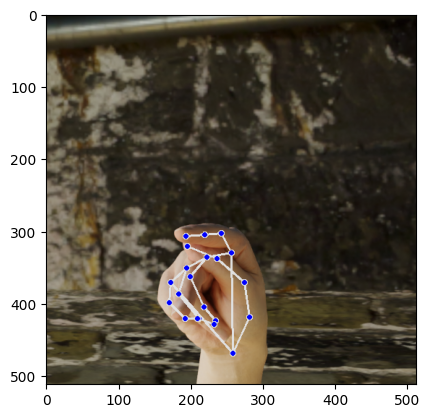

Label: 15


In [187]:
plt.imshow(img_np)
plt.show()
print(f"Label: {labels[i]}")

#### Process All Images

In [ ]:
def process_batch(images, labels):
    imgs_np = (images.permute(0,2,3,1) * 255).byte().cpu().numpy()

    # Iterate through images in batch
    dat_batch = []
    labels_batch = []
    for j, img_np in enumerate(imgs_np):
        # Convert to mediapipe format
        img_np = np.ascontiguousarray(img_np)
        img_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_np)

        # Get embeddings
        res = (detector.detect(img_mp)).hand_landmarks           

        # Add embeddings to result tensor if detected
        if res:
            dat_img = torch.zeros(1, 21, 3)
            for k, lm in enumerate(res[0]):
                dat_img[0,k,0] = lm.x
                dat_img[0,k,1] = lm.y
                dat_img[0,k,2] = lm.z
                
            dat_batch.append(dat_img)
            labels_batch.append(labels[j])

    return dat_batch, labels_batch

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize result
dat_mp = []
labels_mp = []

# Call thread on each batch
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_batch, images, labels) for images, labels in tqdm(loader_tr)}

    # Combine output
    for f in tqdm(as_completed(futures), total=len(futures)):
        dat_batch, labels_batch = f.result()
        dat_mp.append(torch.cat(dat_batch, dim=0))
        labels_mp.append(labels_batch)

100%|██████████| 270/270 [04:12<00:00,  1.07it/s] 


In [312]:
total = 0
for i in dat_mp:
    total += i.shape[0]

total_loader = len(loader_tr)*(loader_tr.batch_size)
undetected = total_loader - total

print("Approximate number of undetected images: " + str(undetected))
print("Approximate percentage of images undetected: " + str(round((undetected/total_loader) * 100, 2)) + "%")

Approximate number of undetected images: 1810
Approximate percentage of images undetected: 10.47%


# Fit Model

In [258]:
import torch.nn as nn
import torch.optim as optim 

#### Initialize Model

In [259]:
# Initialize MLP
num_classes = 24

# Note: output channels are arbitrary
mlp_model = nn.Sequential(
        nn.Linear(21*3, 32),
        nn.ReLU(),

        nn.Linear(32, 16),
        nn.ReLU(),

        nn.Linear(16, num_classes)
    )

In [260]:
# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters())

#### Train Model

In [296]:
# Fit model on data
NUM_EPOCH = 50

count = 0
for epoch in tqdm(range(NUM_EPOCH)):
    curr_loss = 0
    for i, hand_lm in enumerate(dat_mp): # enumerate in batch size
        labels_batch = torch.tensor(labels_mp[i])
        hand_lm = hand_lm.view(hand_lm.size(0), -1)     # flatten embedding

        optimizer.zero_grad()

        outputs = mlp_model(hand_lm)
        loss = criterion(outputs, labels_batch)
        
        loss.backward()
        optimizer.step()
        
        curr_loss += loss.item()

    count += 1
    if count % 5 == 0:
        print("loss: " + str(curr_loss))
        curr_loss = 0

 10%|█         | 5/50 [00:01<00:14,  3.02it/s]

loss: 22.802280641160905


 20%|██        | 10/50 [00:03<00:14,  2.72it/s]

loss: 22.277856695465744


 30%|███       | 15/50 [00:05<00:11,  3.15it/s]

loss: 21.8214526232332


 40%|████      | 20/50 [00:06<00:08,  3.67it/s]

loss: 21.37206375040114


 50%|█████     | 25/50 [00:07<00:06,  3.69it/s]

loss: 20.968029308132827


 60%|██████    | 30/50 [00:09<00:05,  3.73it/s]

loss: 20.619771872181445


 70%|███████   | 35/50 [00:10<00:03,  3.84it/s]

loss: 20.26332948775962


 80%|████████  | 40/50 [00:11<00:02,  3.91it/s]

loss: 19.916374093387276


 90%|█████████ | 45/50 [00:13<00:01,  3.92it/s]

loss: 19.555269406642765


100%|██████████| 50/50 [00:14<00:00,  3.42it/s]

loss: 19.209123945795


# Evaluate Model

#### Train Accuracy

In [281]:
# Train data
correct = 0
total = 0

for i, hand_lm in tqdm(enumerate(dat_mp)):
    labels_batch = torch.tensor(labels_mp[i])
    hand_lm = hand_lm.view(hand_lm.size(0), -1)

    outputs = mlp_model(hand_lm)
    _, predicted = torch.max(outputs, 1)

    correct += (predicted == labels_batch).sum().item()
    total += labels_batch.shape[0]

print("Accuracy: " + str(correct / total))

270it [00:00, 1746.34it/s]

Accuracy: 0.9768584356819651


In [282]:
# Per class accuracy
reverse_map = {dat.class_to_idx[c]: c for c in dat.class_to_idx.keys()}
correct = {c:0 for c in dat.classes}
total = {c:0 for c in dat.classes}

mlp_model.eval()
with torch.no_grad():
    for i, hand_lm in tqdm(enumerate(dat_mp)):
        labels_batch = torch.tensor(labels_mp[i])
        hand_lm = hand_lm.view(hand_lm.size(0), -1)

        outputs = mlp_model(hand_lm)
        _, predicted = torch.max(outputs, 1)

        for lab, pred in zip(labels_batch, predicted):
            if lab == pred:
                correct[reverse_map[lab.item()]] += 1
            total[reverse_map[lab.item()]] += 1
class_accuracy = {c: correct[c] / total[c] if total[c] > 0 else 0 for c in total.keys()}

for c,acc in class_accuracy.items():
    print(f"{c} Accuracy: {acc:.2%}")

270it [00:00, 393.39it/s]

A Accuracy: 97.63%
B Accuracy: 99.10%
C Accuracy: 100.00%
D Accuracy: 91.33%
E Accuracy: 94.89%
F Accuracy: 98.56%
G Accuracy: 99.28%
H Accuracy: 99.71%
I Accuracy: 96.66%
K Accuracy: 98.89%
L Accuracy: 99.08%
M Accuracy: 96.85%
N Accuracy: 93.93%
O Accuracy: 99.85%
P Accuracy: 98.72%
Q Accuracy: 99.85%
R Accuracy: 97.64%
S Accuracy: 97.35%
T Accuracy: 92.99%
U Accuracy: 98.34%
V Accuracy: 98.52%
W Accuracy: 98.44%
X Accuracy: 98.15%
Y Accuracy: 98.09%


#### Process Validation Data

In [284]:
# Initialize result
dat_mp_val = []
labels_mp_val = []

# Call thread on each batch
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_batch, images, labels) for images, labels in tqdm(loader_val)}

    # Combine output
    for f in tqdm(as_completed(futures), total=len(futures)):
        dat_batch, labels_batch = f.result()
        dat_mp_val.append(torch.cat(dat_batch, dim=0))
        labels_mp_val.append(torch.tensor(labels_batch))

  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [01:15<00:00,  1.12s/it]


In [313]:
total = 0
for i in dat_mp_val:
    total += i.shape[0]

total_loader = len(loader_val)*(loader_val.batch_size)
undetected = total_loader - total

print("Approximate number of undetected images: " + str(undetected))
print("Approximate percentage of images undetected: " + str(round((undetected/total_loader) * 100, 2)) + "%")

Approximate number of undetected images: 498
Approximate percentage of images undetected: 11.44%


#### Validation Accuracy

In [285]:
# Val data
correct = 0
total = 0

for i, hand_lm in tqdm(enumerate(dat_mp_val)):
    labels_batch = labels_mp_val[i]
    hand_lm = hand_lm.view(hand_lm.size(0), -1)

    outputs = mlp_model(hand_lm)
    _, predicted = torch.max(outputs, 1)

    correct += (predicted == labels_batch).sum().item()
    total += labels_batch.shape[0]

print("Accuracy: " + str(correct / total))

68it [00:00, 481.85it/s]

Accuracy: 0.9771665801764401


In [286]:
# Per class accuracy
reverse_map = {dat.class_to_idx[c]: c for c in dat.class_to_idx.keys()}
correct = {c:0 for c in dat.classes}
total = {c:0 for c in dat.classes}

mlp_model.eval()
with torch.no_grad():
    for i, hand_lm in tqdm(enumerate(dat_mp_val)):
        labels_batch = torch.tensor(labels_mp_val[i])
        hand_lm = hand_lm.view(hand_lm.size(0), -1)

        outputs = mlp_model(hand_lm)
        _, predicted = torch.max(outputs, 1)

        for lab, pred in zip(labels_batch, predicted):
            if lab == pred:
                correct[reverse_map[lab.item()]] += 1
            total[reverse_map[lab.item()]] += 1
class_accuracy = {c: correct[c] / total[c] if total[c] > 0 else 0 for c in total.keys()}

for c,acc in class_accuracy.items():
    print(f"{c} Accuracy: {acc:.2%}")

0it [00:00, ?it/s]/var/folders/4s/wcc0tbwn4_149r662n1p67x80000gp/T/ipykernel_11207/1644182413.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_batch = torch.tensor(labels_mp_val[i])
68it [00:00, 103.59it/s]

A Accuracy: 97.52%
B Accuracy: 97.18%
C Accuracy: 100.00%
D Accuracy: 91.03%
E Accuracy: 98.65%
F Accuracy: 98.78%
G Accuracy: 98.36%
H Accuracy: 100.00%
I Accuracy: 98.80%
K Accuracy: 96.76%
L Accuracy: 97.40%
M Accuracy: 97.31%
N Accuracy: 95.73%
O Accuracy: 99.36%
P Accuracy: 97.47%
Q Accuracy: 100.00%
R Accuracy: 97.87%
S Accuracy: 97.55%
T Accuracy: 93.90%
U Accuracy: 97.96%
V Accuracy: 98.08%
W Accuracy: 97.58%
X Accuracy: 98.80%
Y Accuracy: 99.32%


#### Save Model Object

In [ ]:
torch.save(mlp_model, "mlp_model.pt")